In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
from astropy.io import fits
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval,SqrtStretch,ZScaleInterval,PercentileInterval,ImageNormalize)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch
from itertools import repeat
from matplotlib.colors import LogNorm
import os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.stats import norm
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Now we condense the whole process and iterate on dates

In [6]:
############################################
## Initialise data and formatting options ##
##      May be improved or automated      ##
############################################
inputdir = '../../AuxTelComm/notebookccdm_gen3/bouguerlines/2022_09/data/'
file_label = 'run-auxtel-holo-{0}-{1}~{2}-config_DECONVOLUTION_PSF1D.pickle' #ou PSF2DFFM ou PSF2D
outdir = './output_files/'

'''
bad_spec_dict = {'20220628':[171,223,250,251,400,425,479,480,538,593,654,655,656,657,683,708],
                 '20220629':[206,304,305,418,420,451,504],
                 '20220630':[50,126,181,182,220,356,410,440,454,455,480,525,566,593]}
'''

bad_spec_dict = {'20220629':[206,304,305,418,420,451,504],
                 '20220630':[50,126,181,182,220,356,410,440,454,455,480,525,566,593]}

if not os.path.exists(outdir):
    os.mkdir(outdir)

obs_dates = bad_spec_dict.keys() #np.array(['20220628', '20220629', '20220630'])
filter_ = 'FELH0600'
disperser = 'holo4_003'
save_txt = True

markerCols = ['green', 'blue', 'red']
errbarCols = ['limegreen', 'cyan', 'magenta']
markerStyle = ['x', 'o', 'v']

abs_min, abs_max = 870.0, 1040.0

In [7]:
#####################################
## Main function definition, could ##
##    be done outside this block   ##
#####################################
def fit_gaussian(x, flux, abs_min, abs_max, central_lambda=None):

    def fun_fit(t, a, b, mu, sigma, k):
        o2abs = norm(loc=mu, scale=sigma)
        return (a*t + b)-k*o2abs.pdf(t)
    
    mask_for_fit = (x >= abs_min) * (x <= abs_max)
    xmasked=x[mask_for_fit]
    if central_lambda is None:
        central_lambda = xmasked[ np.where( flux[mask_for_fit] == np.min(flux[mask_for_fit]) )[0] ][0] ## caution : the minimum could be in the continuum if the interval around the band is too wide
    
    #print("dbg - O2 line center : {} nm".format(central_lambda))
    
    p1, cov = curve_fit(fun_fit, xmasked, flux[mask_for_fit], p0=[1., 0.0, central_lambda, 2.0, 1.0])
    min_cont, max_cont = p1[2] - 5*p1[3], p1[2] + 5*p1[3]
    xmask_continuum = (x >= min_cont) * (x <= max_cont)
    
    mod, cov = curve_fit(fun_fit, x[xmask_continuum], flux[xmask_continuum], p0=[p1[0], p1[1], p1[2], p1[3], p1[4]])
    min_lin, max_lin = mod[2] - 3*mod[3], mod[2] + 3*mod[3]
    min_cont, max_cont = mod[2] - 5*mod[3], mod[2] + 5*mod[3]
    
    limits_ = np.array([min_cont, min_lin, max_lin, max_cont])
    
    return mod, cov, limits_

def eqw_norm(x, flux, abs_min, abs_max, central_lambda=None, gaussMod_band=None, limits=None, fit_band=True, return_fit=False, make_plot=True, plot_name='test.png'): 
    
    def continuum_error(l0, sigma_a, sigma_b):
        return np.sqrt( np.power(sigma_a*l0, 2.) + np.power(sigma_b, 2.) )

    def area_ul_error(flux_error, lambda_vec):
        delta_lambda = np.mean( np.diff(lambda_vec) )
        return np.sqrt( np.sum( np.power(flux_error, 2.) ) * np.power(delta_lambda, 2.) )

    def area_l_error(sigma_area_cont, sigma_area_ul):
        return np.sqrt( np.power(sigma_area_cont, 2.) + np.power(sigma_area_ul, 2.) )

    def eqw_error(cont_at_line, line_area, sigma_cont, sigma_area_line):
        sigma2_eqw = np.power(sigma_area_line / cont_at_line, 2.) + np.power(line_area*sigma_cont / np.power(cont_at_line, 2.), 2.)
        return np.sqrt(sigma2_eqw)
    
    if gaussMod_band is None:
        fit_band=True
    
    if fit_band:
        mod, cov, lims = fit_gaussian(x, flux, abs_min, abs_max, central_lambda)
        init=[mod[0], mod[1]]
        o2_band_centre = mod[2]
        sigmaBand = mod[3]
        kBand = mod[4]
        min_cont, min_lin, max_lin, max_cont = lims[0], lims[1], lims[2], lims[3]
        #delta_line = np.sqrt(cov[2,2])
    else:
        o2_band_centre = gaussMod_band[2]
        sigmaBand = gaussMod_band[3]
        kBand = gaussMod_band[4]
        if limits is None:
            min_lin, max_lin = o2_band_centre - 3*sigmaBand, o2_band_centre + 3*sigmaBand
            min_cont, max_cont = o2_band_centre - 5*sigmaBand, o2_band_centre + 5*sigmaBand
        else:
            min_cont, min_lin, max_lin, max_cont = limits[0], limits[1], limits[2], limits[3]
        init = [ (flux[-1]-flux[0]) / (x[-1]-x[0]), flux[0] - ( (flux[-1]-flux[0]) / (x[-1]-x[0]) )*x[0] ]
    
    def lin_fun(x, a, b):
        return a*x+b
    print(min_cont, min_lin, max_lin, max_cont)
    xmask_contForFit = (x >= min_cont)*(x<=min_lin) + (x<=max_cont)*(x>=max_lin)
    contMod, cov = curve_fit(lin_fun, x[xmask_contForFit], flux[xmask_contForFit], p0=init)
    
    def continuum(x):
        return contMod[0]*x+contMod[1]

    xmask_continuum = (x>=min_cont)*(x<=max_cont)

    mask_for_fit = (x >= abs_min) * (x <= abs_max)
    xline0 = x[mask_for_fit]
    fline0 = flux[mask_for_fit]
    
    xline = x[xmask_continuum]
    fline = flux[xmask_continuum]
    xmask_line = (xline>=min_lin)*(xline<=max_lin)
    xline_model = xline[xmask_line]
    
    def spec_mod(x):
        o2abs = norm(loc=o2_band_centre, scale=sigmaBand)
        return continuum(x)-kBand*o2abs.pdf(x)
    
    fline_model = spec_mod(xline_model)
    
    def normed_cont(x): ## must return 1.
        return continuum(x) / continuum(x)
    def normed_spec(x):
        return spec_mod(x) / continuum(x)
    
    norm_array = continuum(xline)
    
    #area_c, area_c_err = quad(normed_cont, min_lin, max_lin)
    area_c, area_c_err = quad(normed_cont, min_cont, max_cont)
    #area_ul = quad(normed_spec, min_lin, max_lin)[0]
    #area_ul = np.trapz(fline[xmask_line]/norm_array[xmask_line], xline_model)
    area_ul = np.trapz(fline/norm_array, xline)
    #area_c = quad(normed_cont, min_cont, max_cont)[0]
    #area_ul = quad(normed_spec, min_cont, max_cont)[0]
    area_l = area_c-area_ul
    #print(area_c)
    #print(area_ul)
    #print(area_l)
    
    cont_min = continuum(o2_band_centre)
    eqw = area_l #/cont_min
    #print('EQW = ',eqw)
        
    sigma_a = np.sqrt(cov[0,0])
    sigma_b = np.sqrt(cov[1,1])
    
    #print(cont_min)
    #print(area_l)
    #print(area_c_err)
    
    cont_err_ = continuum_error(o2_band_centre, sigma_a, sigma_b)
    #print(cont_err_)
    
    area_ul_err_ = area_ul_error(fline[xmask_line]/continuum(norm_array[xmask_line]), xline_model)
    #print(area_ul_err_)
    
    area_l_err_ = area_l_error(area_c_err, area_ul_err_)
    #print(area_l_err_)
    
    #eqw_err_ = eqw_error(cont_min, area_l_, cont_err_, area_l_err_)
    eqw_err_ = eqw_error(1., area_l, cont_err_, area_l_err_)
    #print(eqw_err_)
    
    #print('----------')
    
    eqwmask = (xline_model>=o2_band_centre-eqw/2.)*(xline_model<=o2_band_centre+eqw/2.)
    #print(continuum)
    #print(xmin_line-eqw/2.,xmin_line+eqw/2.)
    
    if make_plot:
        fig, axs=plt.subplots(1,2,figsize=(10,6), constrained_layout=True)
        axs=axs.ravel()
        axs[0].scatter(xline0, fline0, marker="+", label="Observed fluxes")
        axs[0].plot(xline0, continuum(xline0), ls='--', color='orange', label="Continuum model")
        axs[0].plot(xline0, spec_mod(xline0), ls='-', color='purple', label="Flux model")
        axs[0].axvline(x=min_lin,color='b',ls='--', label="3 sigma : O2 absorption model boundaries")
        axs[0].axvline(x=max_lin,color='b',ls='--')
        axs[0].axvline(x=min_cont,color='r',ls='--', label="5 sigma : boundaries of the model")
        axs[0].axvline(x=max_cont,color='r',ls='--')
        axs[0].fill_between(xline, continuum(xline), fline, color='gray',alpha=0.2, label="Ref. surface")
        #axs[0].fill_between(xline_model[eqwmask], continuum(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        #axs[0].fill_between(xline_model, continuum(xline_model), spec_mod(xline_model), color='gray',alpha=0.2, label="Ref. surface")
        axs[0].fill_between(xline_model[eqwmask], continuum(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        axs[1].set_xlabel(r'$\lambda \, [nm]$',fontsize=12)
        axs[0].set_ylabel(r'$\gamma \, [s \cdot cm^2 \cdot nm]$',fontsize=12)
        axs[0].grid()
        axs[0].legend(loc="lower right")
        
        
        axs[1].scatter(xline, fline/norm_array, marker="+", label="Normalised observed fluxes")
        axs[1].plot(xline, normed_cont(xline), ls='--', color='orange', label="Continuum model")
        axs[1].plot(xline, normed_spec(xline), ls='-', color='purple', label="Flux model")
        axs[1].axvline(x=min_lin,color='b',ls='--', label="3 sigma : O2 absorption model boundaries")
        axs[1].axvline(x=max_lin,color='b',ls='--')
        axs[1].axvline(x=min_cont,color='r',ls='--', label="5 sigma : boundaries of the model")
        axs[1].axvline(x=max_cont,color='r',ls='--')
        axs[1].axvline(x=o2_band_centre,color='k',ls=':', label="O2 line center")
        axs[1].fill_between(xline, normed_cont(xline), fline/norm_array, color='gray',alpha=0.2, label="Ref. surface")
        #axs[1].fill_between(xline_model[eqwmask], normed_cont(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        #axs[1].fill_between(xline_model, normed_cont(xline_model), normed_spec(xline_model), color='gray',alpha=0.2, label="Ref. surface")
        axs[1].fill_between(xline_model[eqwmask], normed_cont(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        axs[1].set_xlabel(r'$\lambda \, [nm]$',fontsize=12)
        axs[1].set_ylabel(r'$\gamma \, / continuum [-]$',fontsize=12)
        axs[1].grid()
        axs[1].legend(loc="lower right")
        
        fig.suptitle("Figure : "+plot_name)
        '''
        plot_outdir = 'output_plots/eqw_line_fit_{0}/'.format(source_spec)
        if os.path.exists(plot_outdir)==False:
            os.mkdir(plot_outdir)
        plt.savefig(plot_outdir+plot_name) 
        '''
    if return_fit:
        return eqw, sigmaBand, eqw_err_, mod, cov, xline, fline, continuum(xline), cont_min, area_l, area_c_err
    else:
        return eqw, sigmaBand, eqw_err_, area_c_err, cont_err_, area_ul_err_, area_l_err_

Widest band identified for exposure No. 87, std HD142331, air mass=1.1648
Lower limit for continuum identified for exposure No. 87, std HD142331, air mass=1.1648
Lower limit for band identified for exposure No. 87, std HD142331, air mass=1.1648
Upper limit for band identified for exposure No. 87, std HD142331, air mass=1.1648
Upper limit for continuum identified for exposure No. 87, std HD142331, air mass=1.1648
Widest band identified for exposure No. 363, std HD185975, air mass=1.8675
Lower limit for continuum identified for exposure No. 363, std HD185975, air mass=1.8675
Lower limit for band identified for exposure No. 363, std HD185975, air mass=1.8675
Upper limit for band identified for exposure No. 363, std HD185975, air mass=1.8675
Upper limit for continuum identified for exposure No. 363, std HD185975, air mass=1.8675
Widest band identified for exposure No. 366, std HD185975, air mass=1.8667
Lower limit for continuum identified for exposure No. 366, std HD185975, air mass=1.8667

Text(0.5, 0.98, 'Equivalent width calculation with a gaussian absorption band to constraint the continuum law fit')

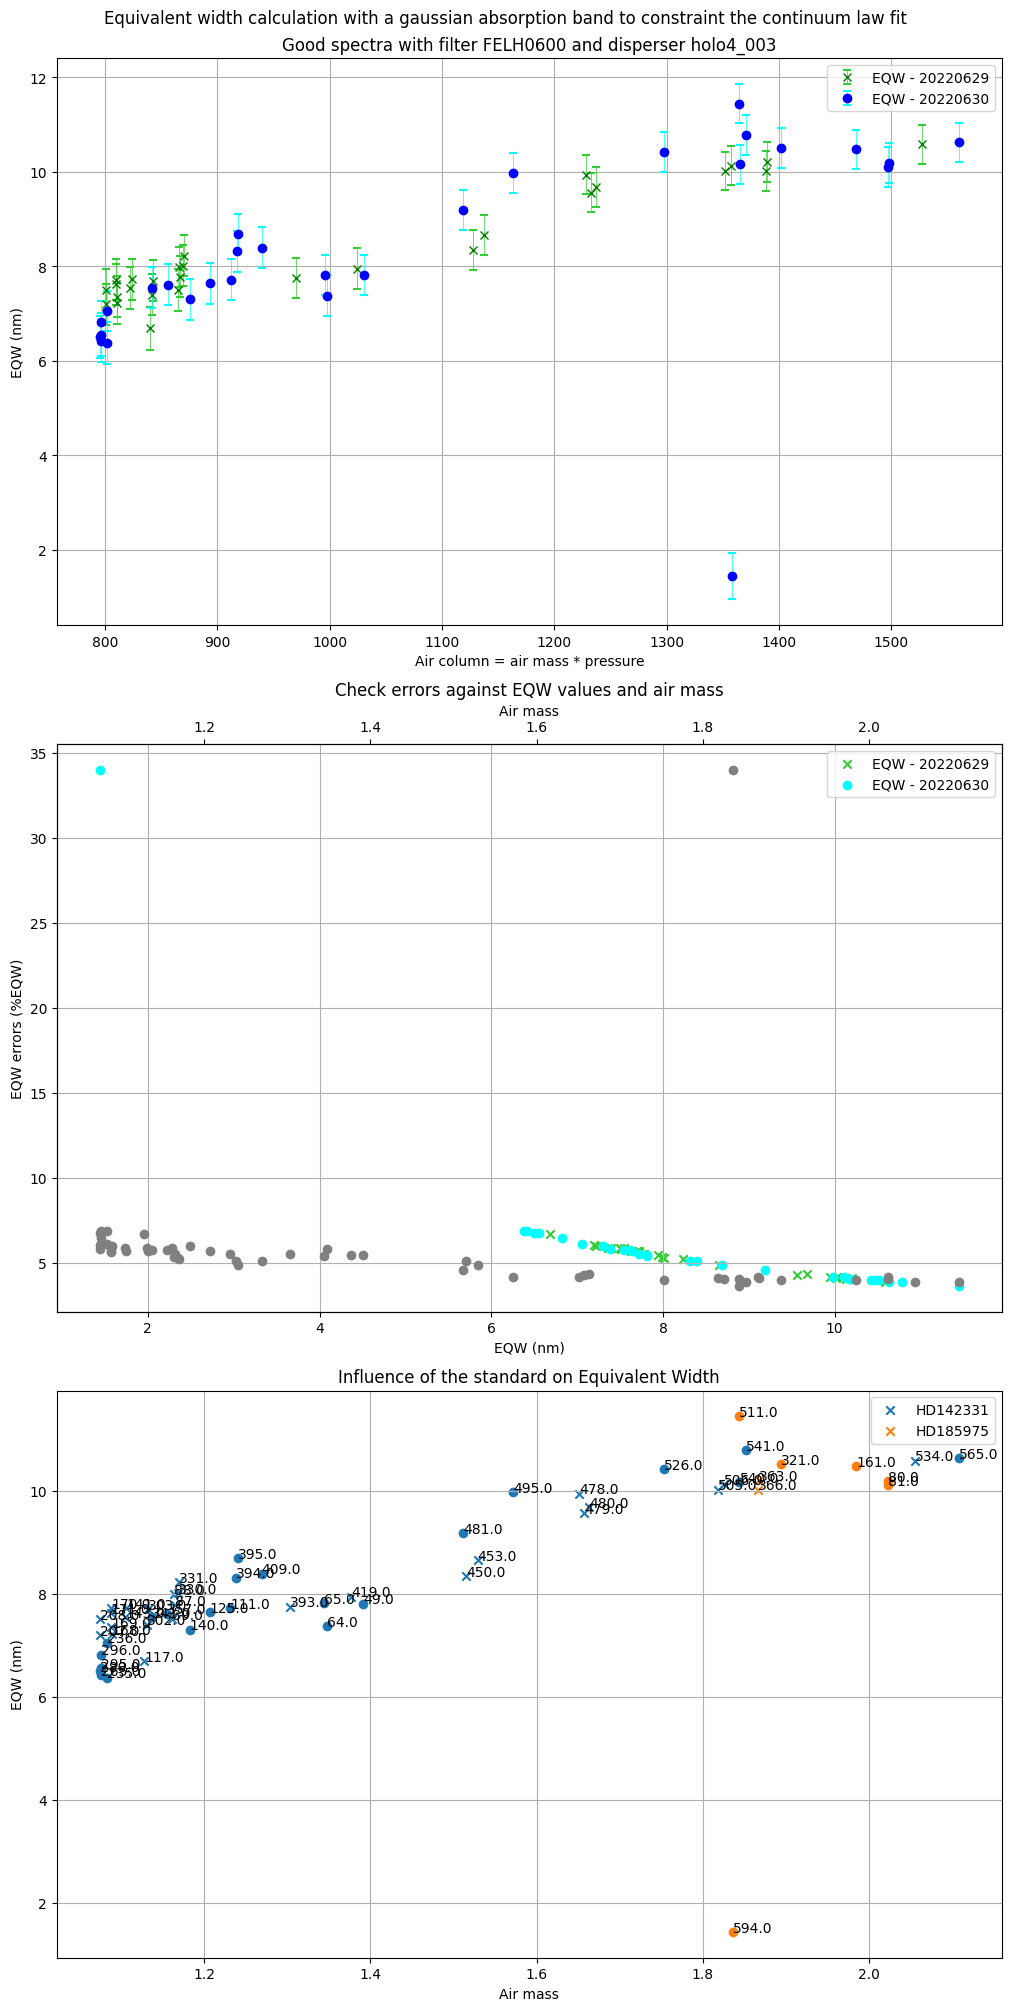

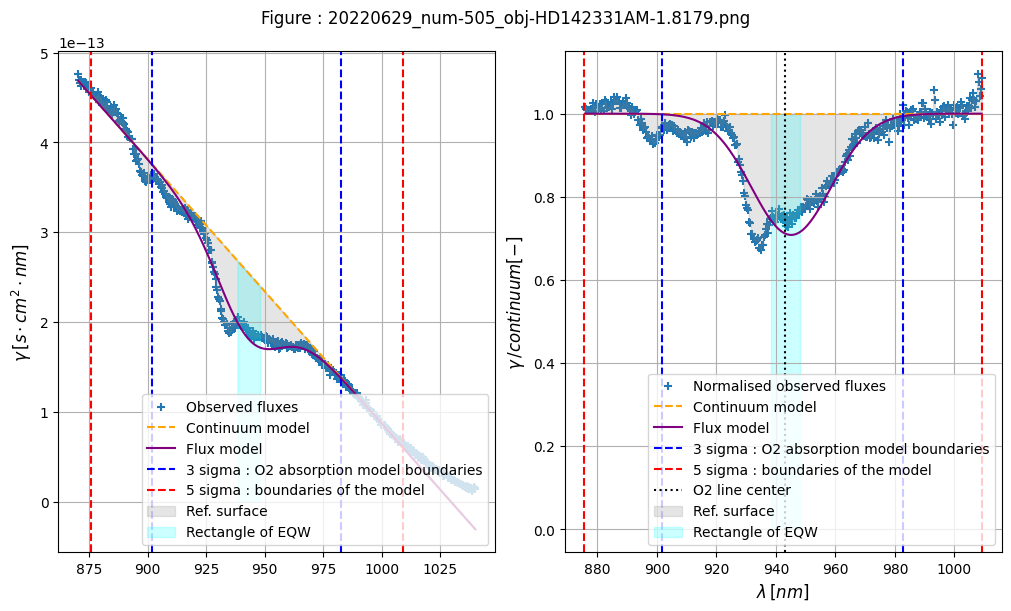

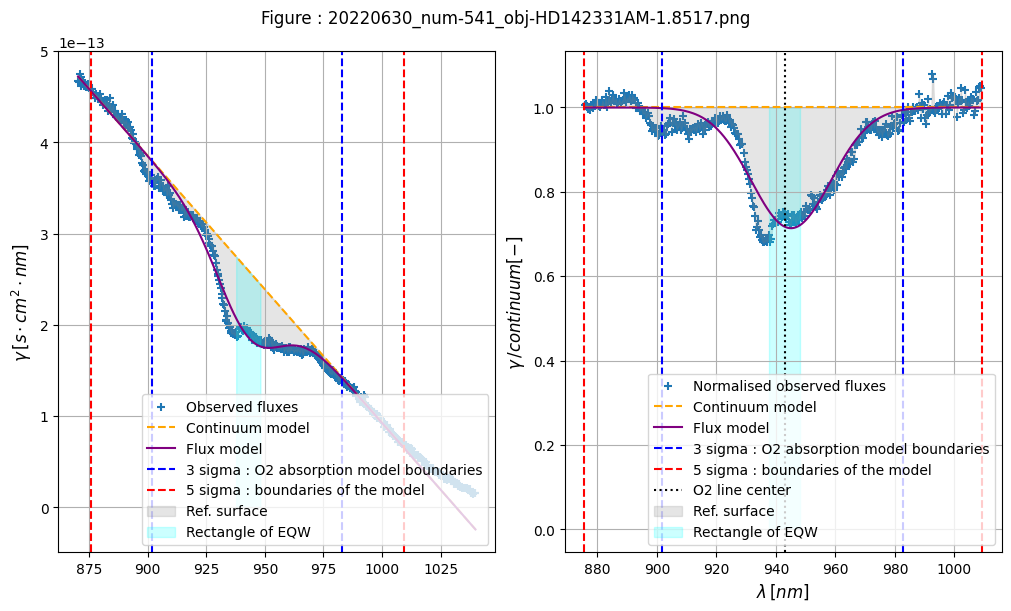

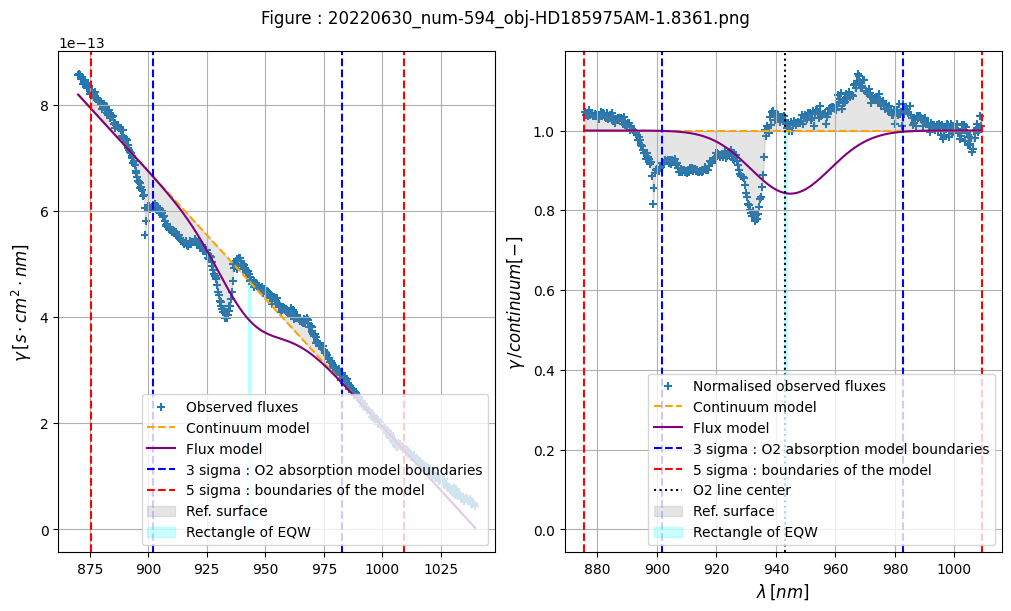

In [8]:
#########################################    
## Run everything and iterate on dates ##
#########################################
fig, axs = plt.subplots(3, 1, figsize=(10,20), constrained_layout=True)
axs = axs.ravel()

all_airmasses = np.empty_like([])
all_pressures = np.empty_like([])
all_eqws = np.empty_like([])
all_eqwerrs = np.empty_like([])
all_area_c_errs = np.empty_like([])
all_cont_errs = np.empty_like([])
all_area_ul_errs = np.empty_like([])
all_area_l_errs = np.empty_like([])
all_numbers = np.empty_like([])
all_objects = np.empty_like([])
targetList = []

maxSigma = 0.
refO2 = 950.
gaussMod, gaussCov = np.empty_like([]), np.empty_like([])
borneInf_cont, borneInf_band, borneSup_band, borneSup_cont = refO2, refO2, refO2, refO2

for obs_date in obs_dates:
    inputfile = os.path.join( inputdir, file_label.format(obs_date, filter_, disperser) )
    with open(inputfile,'rb') as f:
        spec_dict = pickle.load(f)
    
    bad_spec = bad_spec_dict[obs_date]

    spec_dict_good = {}
    for key in spec_dict.keys():
        if int(spec_dict[key]['number']) not in bad_spec:
            spec_dict_good[key] = spec_dict[key]
            
    for spec in spec_dict_good:
        lambda_ = spec_dict_good[spec]['all_lambdas']
        flux_ = spec_dict_good[spec]['all_fluxes']
        
        gaussMod_, cov, lims_ = fit_gaussian(lambda_, flux_, abs_min, abs_max, central_lambda=refO2)
        if gaussMod_[3] > maxSigma:
            maxSigma = gaussMod_[3]
            refO2 = gaussMod_[2]
            gaussMod = gaussMod_
            gaussCov = cov
            print("Widest band identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        if lims_[0] < borneInf_cont:
            borneInf_cont = lims_[0]
            print("Lower limit for continuum identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        if lims_[1] < borneInf_band:
            borneInf_band = lims_[1]
            print("Lower limit for band identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        if lims_[2] > borneSup_band:
            borneSup_band = lims_[2]
            print("Upper limit for band identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        if lims_[3] > borneSup_cont:
            borneSup_cont = lims_[3]
            print("Upper limit for continuum identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        lims = np.array([borneInf_cont, borneInf_band, borneSup_band, borneSup_cont])
_loc=-1
for obs_date, mstyle, mcol, ecol in zip(obs_dates, markerStyle, markerCols, errbarCols):
    _loc += 1
    inputfile = os.path.join( inputdir, file_label.format(obs_date, filter_, disperser) )
    with open(inputfile,'rb') as f:
        spec_dict = pickle.load(f)
    
    bad_spec = bad_spec_dict[obs_date]

    spec_dict_good = {}
    for key in spec_dict.keys():
        if int(spec_dict[key]['number']) not in bad_spec:
            spec_dict_good[key] = spec_dict[key]

    #ref_obs = 'exposure_2022062800143_postisrccd_spectrum.fits'
    #lambda_ref = spec_dict_good[ref_obs]['all_lambdas']
    #flux_ref = spec_dict_good[ref_obs]['all_fluxes']

    airmass = np.empty_like([])
    pressure = np.empty_like([])
    eqwidths = np.empty_like([])
    eqw_errs = np.empty_like([])
    numbers = np.empty_like([])
    objects = np.empty_like([])
    loc=-1
    for spec in spec_dict_good:
        loc += 1
        airmass_ = spec_dict_good[spec]['airmass']
        pressure_ = spec_dict_good[spec]['pressure']
        lambda_ = spec_dict_good[spec]['all_lambdas']
        flux_ = spec_dict_good[spec]['all_fluxes']
        flux_err_ = spec_dict_good[spec]['all_fluxes_err']
        expNum_ = spec_dict_good[spec]['number']
        object_ = spec_dict_good[spec]['object']
        if not object_ in targetList:
            targetList.append(object_)

        '''
        if loc%10 == 0 :
            eqw_, eqw_err_, mod, cov, xline, fline, xcontinuum, cont_at_line, area_l_, area_c_err_ = eqw_norm(lambda_, flux_, abs_min, abs_max, make_plot=True, return_fit=True, plot_name="{}_AM-{:.4f}.png".format(obs_date, airmass_))
        else:
            eqw_, eqw_err_, mod, cov, xline, fline, xcontinuum, cont_at_line, area_l_, area_c_err_ = eqw_norm(lambda_, flux_, abs_min, abs_max, make_plot=False, return_fit=True)
        '''
        
        #if loc%10 == 0 :
        if expNum_ in [505, 541, 594]:
            eqw_, bandWidth, eqw_err_, area_c_err, cont_err_, area_ul_err_, area_l_err_ = eqw_norm(lambda_, flux_, abs_min, abs_max, gaussMod_band=gaussMod, limits=lims, fit_band=False, make_plot=True, return_fit=False, plot_name="{}_num-{:.0f}_obj-{}AM-{:.4f}.png".format(obs_date, expNum_, object_, airmass_))
        else:
            eqw_, bandWidth, eqw_err_, area_c_err, cont_err_, area_ul_err_, area_l_err_ = eqw_norm(lambda_, flux_, abs_min, abs_max, gaussMod_band=gaussMod, limits=lims, fit_band=False, make_plot=False, return_fit=False)

        '''
        if eqwdb_<0.:
            print(seqn)
            plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
            eqwdb_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
        elif eqwdf_<0.:
            print(seqn)
            plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
            eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)

        plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
        eqw0_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)

        plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
        eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
        '''
        
        airmass = np.append(airmass, airmass_)
        pressure = np.append(pressure, pressure_)
        eqwidths = np.append(eqwidths, eqw_)
        eqw_errs = np.append(eqw_errs, eqw_err_)
        numbers = np.append(numbers, expNum_)
        objects = np.append(objects, object_)
        
        all_airmasses = np.append(all_airmasses, airmass_)
        all_pressures = np.append(all_pressures, pressure_)
        all_eqws = np.append(all_eqws, eqw_)
        all_eqwerrs = np.append(all_eqwerrs, eqw_err_)
        all_area_c_errs = np.append(all_area_c_errs, area_c_err)
        all_cont_errs = np.append(all_cont_errs, cont_err_)
        all_area_ul_errs = np.append(all_area_ul_errs, area_ul_err_)
        all_area_l_errs = np.append(all_area_l_errs, area_l_err_)
        all_numbers = np.append(all_numbers, expNum_)
        all_objects = np.append(all_objects, object_)
    if save_txt:
        data = np.transpose(np.array([numbers, airmass, pressure, eqwidths, eqw_errs]))
        np.savetxt(os.path.join(outdir,'eqw_data_{0}_{1}_{2}.txt'.format(obs_date, filter_, disperser)), data, header='id airmass pressure eqw eqw_err')
    
    targetList = np.array(targetList)
    axs[0].errorbar(airmass*pressure, eqwidths, yerr=eqw_errs, ls='', marker=mstyle, color=mcol, ecolor=ecol, elinewidth=.5, capsize=3, capthick=1.5, label="EQW - {}".format(obs_date))
    axs[1].scatter(eqwidths, 100.*eqw_errs/eqwidths, marker=mstyle, color=ecol, label="EQW - {}".format(obs_date))
    for target,col in zip(targetList, ['tab:blue', 'tab:orange', 'tab:green']):
        if _loc == 0:
            axs[2].scatter(airmass[objects == target], eqwidths[objects == target], marker=mstyle, color=col, label=target)
        else:
            axs[2].scatter(airmass[objects == target], eqwidths[objects == target], marker=mstyle, color=col)

###################
# format the plot #
###################
axs[0].grid()
axs[0].set_xlabel("Air column = air mass * pressure")
axs[0].set_ylabel("EQW (nm)")
axs[0].set_title("Good spectra with filter {} and disperser {}".format(filter_, disperser))
axs[0].legend()

axs11=axs[1].twiny()
axs11.scatter(all_airmasses, 100.*all_eqwerrs/all_eqws, color="gray")
axs11.set_xlabel("Air mass")

axs[1].grid()
axs[1].set_ylabel("EQW errors (%EQW)")
axs[1].set_xlabel("EQW (nm)")
axs[1].set_title("Check errors against EQW values and air mass")
axs[1].legend()

for am, eqw, num in zip(all_airmasses, all_eqws, all_numbers):
    axs[2].text(am, eqw, num)
axs[2].grid()
axs[2].set_ylabel("EQW (nm)")
axs[2].set_xlabel("Air mass")
axs[2].set_title("Influence of the standard on Equivalent Width")
#axs[2].scatter(all_airmasses, np.power(all_eqwerrs, 2.), color="gray", label="total variance")
#axs[2].scatter(all_airmasses, np.power(all_area_l_errs, 2.), color="blue", label="from surface computation")
#axs[2].scatter(all_airmasses, np.power(all_cont_errs*all_eqws, 2.), color="red", label="from continuum estimation")
#axs[2].set_yscale('log')
#axs[2].grid()
#axs[2].set_ylabel("EQW errors (nm)")
#axs[2].set_xlabel("Air mass")
#axs[2].set_title("Check errors against air mass")
axs[2].legend()
fig.suptitle("Equivalent width calculation with a gaussian absorption band to constraint the continuum law fit")

# Attempt to compare to libradtran sim here

In [9]:
import sys
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.interpolate import interp1d
from libradtranpy import libsimulateVisible
from tools.equivalentWidth import *

libradtranpath= /home/joseph/libRadtran/


Success in the step above looks good ! 

In [10]:
matplotlib.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'lines.markersize': 15})
matplotlib.rcParams["axes.labelsize"]="small"
matplotlib.rcParams["axes.linewidth"]=2.0
matplotlib.rcParams["xtick.major.size"]=8
matplotlib.rcParams["ytick.major.size"]=8
matplotlib.rcParams["ytick.minor.size"]=5
matplotlib.rcParams["xtick.labelsize"]="large"
matplotlib.rcParams["ytick.labelsize"]="large"
matplotlib.rcParams["figure.figsize"]=(12,6)
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
#matplotlib.rcParams['axes.facecolor'] = 'blue'
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
matplotlib.rcParams['lines.markersize'] = 10  # markersize, in points
matplotlib.rcParams['grid.alpha'] = 1. # transparency, between 0.0 and 1.0
matplotlib.rcParams['grid.linestyle'] = '-' # simple line
matplotlib.rcParams['grid.linewidth'] = 0.4 # in points 
os.getenv('LIBRADTRANDIR')

'/home/joseph/libRadtran'

In [11]:
AMMIN=1
AMMAX=2.3
AMSTEP = 0.1
all_am=np.arange(AMMIN,AMMAX,AMSTEP)
pressure = 0. # use default value
all_pwv=np.arange(0.0, 5., 0.5)
aer=0
ozone=300.
cloudext=0
atmStd='us'
NBOBS=len(all_am)
NBPWM=len(all_pwv)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange( NBOBS), alpha=1)

h2o_line=gaussMod[2]
print(h2o_line)
sigmaBand_=gaussMod[3]
min_wl, max_wl = abs_min, abs_max
limInf_cont, limInf_band, limSup_band, limSup_cont = h2o_line, h2o_line, h2o_line, h2o_line
gaussianMod, gaussianCov = gaussMod, gaussCov

943.066668492306


In [17]:
if True:
    all_trans = []
    for index in np.arange(NBOBS):
        am = all_am[index]
        print("simulate index=",index," airmass = ",am)
        path,thefile=libsimulateVisible.ProcessSimulation(am,all_pwv[1],ozone,pressure,
                                                          prof_str=atmStd,proc_str='sa',cloudext=cloudext)
        data = np.loadtxt(os.path.join(path[0],thefile[0]))
        wl = data[:,0]
        atm = data[:,1] 
        all_trans.append(atm)

simulate index= 0  airmass =  1.0
simulate index= 1  airmass =  1.1
simulate index= 2  airmass =  1.2000000000000002
simulate index= 3  airmass =  1.3000000000000003
simulate index= 4  airmass =  1.4000000000000004
simulate index= 5  airmass =  1.5000000000000004
simulate index= 6  airmass =  1.6000000000000005
simulate index= 7  airmass =  1.7000000000000006
simulate index= 8  airmass =  1.8000000000000007
simulate index= 9  airmass =  1.9000000000000008
simulate index= 10  airmass =  2.000000000000001


******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from 

simulate index= 11  airmass =  2.100000000000001
simulate index= 12  airmass =  2.200000000000001


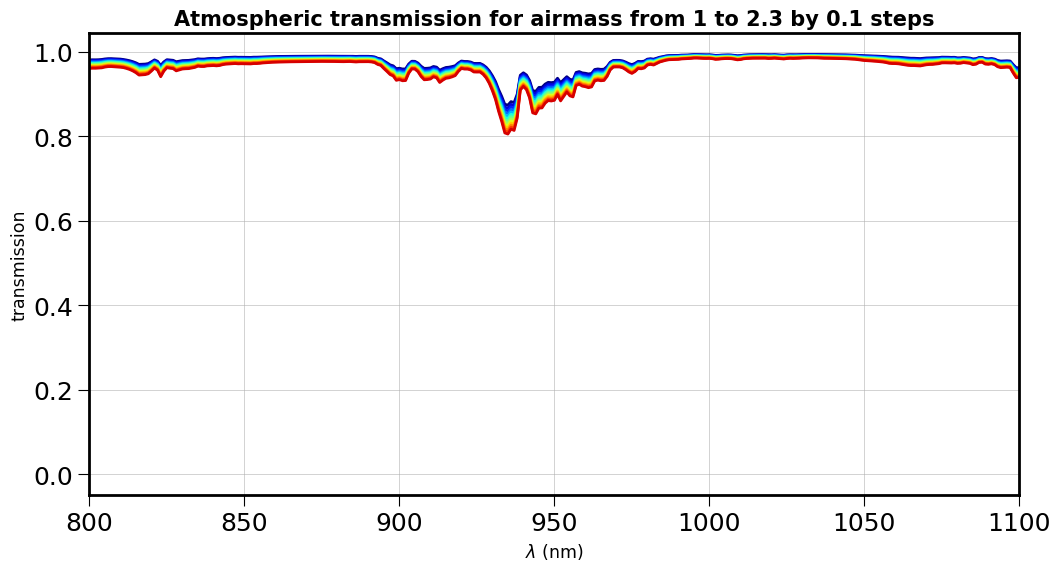

In [18]:
if True:
    for index in np.arange(NBOBS):   
        plt.plot(wl,all_trans[index],'-',color=all_colors[index])
    plt.xlim(300,1200)
    plt.grid()
    plt.title(f"Atmospheric transmission for airmass from {AMMIN} to {AMMAX} by {AMSTEP} steps")
    plt.xlabel("$\\lambda$ (nm)")
    plt.ylabel("transmission")
    #plt.ylim(0.5,1)
    plt.xlim(800.,1100.)
    figname="multitransmission.png"
    plt.savefig(figname)

In [14]:
ids, airmasses, pressures, eqwidths, eqw_errs = np.loadtxt(os.path.join(outdir,'eqw_data_20220629_FELH0600_holo4_003.txt'), skiprows=1, unpack=True)
ids1, airmasses1, pressures1, eqwidths1, eqw_errs1 = np.loadtxt(os.path.join(outdir,'eqw_data_20220630_FELH0600_holo4_003.txt'), skiprows=1, unpack=True)
print(len(ids), len(ids1))
gaussianLimits = lims #determined on observations
print(gaussianLimits)
print(min_wl, max_wl)

28 29
[ 875.68167017  901.89233473  982.75385046 1009.21197177]
870.0 1040.0


us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp
us
sw
ss
mw
ms
tp


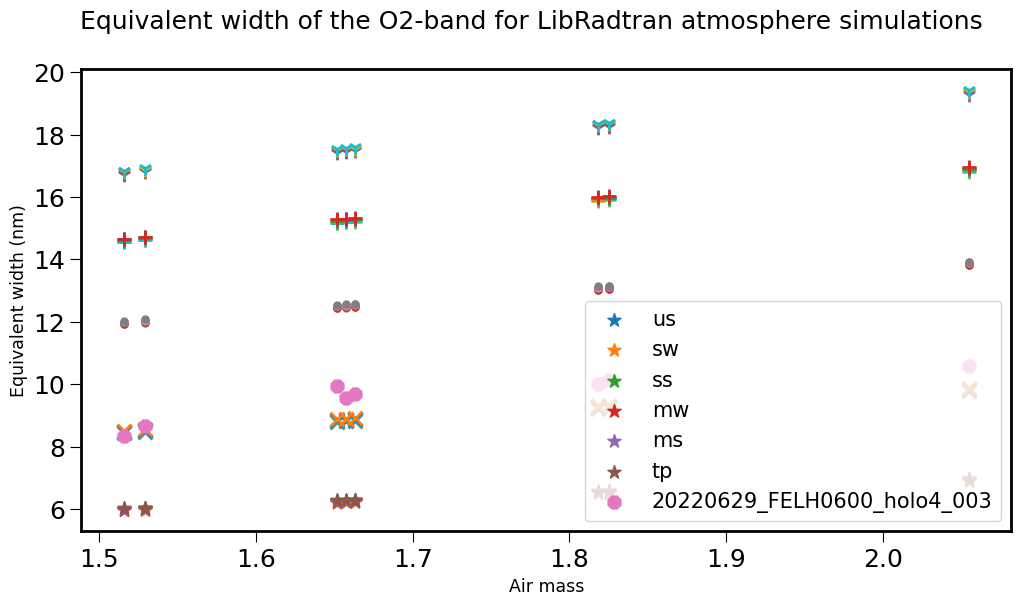

In [20]:
if True:
    fig, ax = plt.subplots(1,1)
    for p, m in zip([1.0, 2.0, 4.0, 6.0, 8.0], ['*', 'x', '.', '+', '1']):
        atmosEQWS_listOfArrays = simAtmEqw(airmasses[20:], pressures[20:], wl_min=min_wl, wl_max=max_wl, wl_mid=h2o_line, lims=gaussianLimits, pwv=p, oz=300.0, atm='all', inter='sa', clouds=0.0, flagVerbose=False)
        for atmType,c in zip(atmosEQWS_listOfArrays[0][:,0], ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']):
            list_eqw_type = []
            for j in np.arange(len(airmasses[20:])):
                list_eqw_type.append(float(atmosEQWS_listOfArrays[j][atmosEQWS_listOfArrays[j][:,0] == atmType, 1][0]))
            if p == 1.:
                lab=atmType
            else:
                lab=''
            ax.scatter(airmasses[20:], list_eqw_type, label=lab, marker=m)
    ax.scatter(airmasses[20:], eqwidths[20:], label="20220629_FELH0600_holo4_003", color="tab:pink", marker="8")
    ax.set_xlabel("Air mass")
    ax.set_ylabel("Equivalent width (nm)")
    ax.legend()
    fig.suptitle("Equivalent width of the O2-band for LibRadtran atmosphere simulations")